### Questions

- What does label look like if no raccoons?
- How is loss calculated for bounding box?

### Thoughts

- if we resize, we have to rescale bounding box also

In [33]:
import cv2
import time
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

import torchvision

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [26]:
data_path = './Data/Racoon Images/images'
df = pd.read_csv('./Data/train_labels_.csv')

In [11]:
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


In [16]:
# Look at an image
path = data_path + '/' + df.iloc[0]['filename']
img = cv2.imread(path)
img.shape

(194, 259, 3)

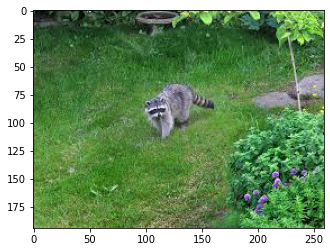

In [20]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [7]:
# smallest w,h
df['width'].min(), df['height'].min()

(178, 154)

In [23]:
# Rescale bounding box in preparation for rescaling images
image_size = 128
df['xmin2'] = df['xmin']*image_size/df['width']
df['xmax2'] = df['xmax']*image_size/df['width']
df['ymin2'] = df['ymin']*image_size/df['height']
df['ymax2'] = df['ymax']*image_size/df['height']

In [24]:
df

,filename,width,height,class,xmin,ymin,xmax,ymax,xmin2,ymin2,xmax2,ymax2
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118,46.949807,39.587629,82.532819,77.855670
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431,0.581818,0.296296,89.406061,127.703704
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290,15.786667,34.240000,59.733333,92.800000
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298,48.426667,29.760000,85.973333,95.360000
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127,27.194139,22.832432,92.366300,87.870270
...,...,...,...,...,...,...,...,...,...,...,...,...
168,raccoon-137.jpg,320,240,raccoon,71,8,304,233,28.400000,4.266667,121.600000,124.266667
169,raccoon-171.jpg,224,225,raccoon,108,21,180,115,61.714286,11.946667,102.857143,65.422222
170,raccoon-190.jpg,259,194,raccoon,78,54,153,135,38.548263,35.628866,75.613900,89.072165
171,raccoon-22.jpg,640,360,raccoon,252,76,466,335,50.400000,27.022222,93.200000,119.111111


In [31]:
!mkdir Data/Racoon\ Images/images_rs

In [39]:
# Resize images before training
def resize_img(path, newpath, size):
    img = cv2.imread(path)
    
    start = time.time()
    img = cv2.resize(img, size)
    end = time.time()
    
    cv2.imwrite(newpath, img)
    return end - start

# resize all of the images
total_time_resize = 0.0
for idx in tqdm(range(len(df))):
    row = df.iloc[idx]
    fname = row['filename']
    path = data_path + '/' + row['filename']
    newpath = './Data/Racoon Images/images_rs'+'/'+fname
    
    total_time_resize += resize_img(path, newpath, (image_size, image_size))
total_time_resize

  0%|          | 0/173 [00:00<?, ?it/s]

In [40]:
# Train/valid split
valid = df.sample(frac=.2)
train = df.drop(valid.index)
len(train),len(valid)

(138, 35)